In [1]:
import itertools
import shutil
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from src.api.controllers.calibration_controller import (
    AnnotatedClassResponse,
    get_annotated_classes,
    recording_uuid_to_calibration_id,
)
from src.config import UNKNOWN_CLASS_ID
from ultralytics import YOLO

from controlled_experiment.prediction_utils import (
    calculate_metrics,
    create_confusion_matrix,
    evaluate_predictions,
    render_confusion_matrix,
    update_confusion_matrix,
)
from controlled_experiment.settings import (
    CLASS_ID_TO_NAME,
    FINAL_PREDICTIONS_PATH,
    FULLY_LABELED_RECORDINGS,
    GAZE_SEGMENTATION_RESULTS_PATH,
    LABELING_REC_DIFF_BACKGROUND_UUID,
    LABELING_REC_SAME_BACKGROUND_UUID,
    OBJECT_DATASETS_PATH,
    TRAINING_DATASETS_PATH,
    YOLO_MODELS_PATH,
)

%matplotlib inline

E0000 00:00:1744911105.352980  151224 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744911105.372293  151224 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [2]:
model = YOLO("yolo11n-cls.pt")

# Create Training Data



In [3]:
def save_roi(roi: np.ndarray, out_dir: Path, file_idx: int, class_id: str):
    """
    Save an ROI crop in <out_dir>/<class_id>/<file>.png
    """
    class_dir = out_dir / class_id  # one subdir per class
    class_dir.mkdir(parents=True, exist_ok=True)

    filename = f"{file_idx:06d}_{class_id}.png"
    cv2.imwrite(str(class_dir / filename), roi)


def create_dataset(
    annotated_classes: list["AnnotatedClassResponse"],
    dataset_path: Path,
) -> None:
    """
    Creates a balanced 90 %/10 % train/val split with no padding.

    Resulting structure:
        dataset_path/
          train/
            <class_id>/*.png
          val/
            <class_id>/*.png
    """
    # start fresh
    if dataset_path.exists():
        shutil.rmtree(dataset_path)

    train_root = dataset_path / "train"
    val_root = dataset_path / "val"
    train_root.mkdir(parents=True, exist_ok=True)
    val_root.mkdir(parents=True, exist_ok=True)

    # -------------------------------------------------------------
    # 1. Collect ROIs per class
    # -------------------------------------------------------------
    rois_per_class: dict[str, list[np.ndarray]] = {}
    for anno in annotated_classes:
        cid = str(anno.id)
        rois_per_class.setdefault(cid, [])
        for npz_path in anno.annotation_paths:
            roi = np.load(npz_path)["roi"]
            roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            rois_per_class[cid].append(roi)

    # drop empty classes
    rois_per_class = {c: r for c, r in rois_per_class.items() if r}
    if not rois_per_class:
        raise ValueError("No class contains any ROI images.")

    # -------------------------------------------------------------
    # 2. Balance by the smallest class size
    # -------------------------------------------------------------
    min_samples = min(len(r) for r in rois_per_class.values())
    rng = np.random.default_rng(seed=42)

    # -------------------------------------------------------------
    # 3. Split and save
    # -------------------------------------------------------------
    global_idx = 0
    for cid, rois in rois_per_class.items():
        idxs = rng.choice(len(rois), size=min_samples, replace=False)
        selected = [rois[i] for i in idxs]

        split = int(0.9 * min_samples)
        train_split, val_split = selected[:split], selected[split:]

        for roi in train_split:
            save_roi(roi, train_root, global_idx, cid)
            global_idx += 1
        for roi in val_split:
            save_roi(roi, val_root, global_idx, cid)
            global_idx += 1

In [4]:
same_background_calibration_id = recording_uuid_to_calibration_id(
    LABELING_REC_SAME_BACKGROUND_UUID
)
diff_background_calibration_id = recording_uuid_to_calibration_id(
    LABELING_REC_DIFF_BACKGROUND_UUID
)

# Check what the minimum number of samples per class is:
annotated_classes_same_background = get_annotated_classes(same_background_calibration_id)
annotated_classes_diff_background = get_annotated_classes(diff_background_calibration_id)
all_annotated_classes = (
    annotated_classes_same_background + annotated_classes_diff_background
)

create_dataset(
    annotated_classes_same_background, TRAINING_DATASETS_PATH / "same_background"
)
# create_dataset(annotated_classes_diff_background, TRAINING_DATASETS_PATH / "diff_background")
# create_dataset(all_annotated_classes, TRAINING_DATASETS_PATH / "combined_background")

# Train Models

In [5]:
anno_classes = get_annotated_classes(diff_background_calibration_id)
class_ids = [str(anno.id) for anno in anno_classes]
results = model.train(
    data=TRAINING_DATASETS_PATH / "same_background",
    epochs=100,
    imgsz=224,
    device="cuda",
    batch=256,
)

New https://pypi.org/project/ultralytics/8.3.110 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.67 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=data/training_datasets/same_background, epochs=100, time=None, patience=100, batch=128, imgsz=224, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False,

train: Scanning /home/zilian/projects/bachelorproef/experiments/controlled_experiment/data/training_datasets/same_background/train... 8542 images, 203 corrupt: 100%|██████████| 8745/8745 [00:03<00:00, 2509.31it/s]

train: WARNING ⚠️ /home/zilian/projects/bachelorproef/experiments/controlled_experiment/data/training_datasets/same_background/train/11/006498_11.png: ignoring corrupt image/label: image size (7, 30) <10 pixels
train: WARNING ⚠️ /home/zilian/projects/bachelorproef/experiments/controlled_experiment/data/training_datasets/same_background/train/11/006558_11.png: ignoring corrupt image/label: image size (8, 29) <10 pixels
train: WARNING ⚠️ /home/zilian/projects/bachelorproef/experiments/controlled_experiment/data/training_datasets/same_background/train/11/006568_11.png: ignoring corrupt image/label: image size (9, 29) <10 pixels
train: WARNING ⚠️ /home/zilian/projects/bachelorproef/experiments/controlled_experiment/data/training_datasets/same_background/train/11/006575_11.png: ignoring corrupt image/label: image size (9, 29) <10 pixels
train: WARNING ⚠️ /home/zilian/projects/bachelorproef/experiments/controlled_experiment/data/training_datasets/same_background/train/11/006576_11.png: ignor


val: Scanning /home/zilian/projects/bachelorproef/experiments/controlled_experiment/data/training_datasets/same_background/val... 961 images, 14 corrupt: 100%|██████████| 975/975 [00:00<00:00, 2187.52it/s]

val: WARNING ⚠️ /home/zilian/projects/bachelorproef/experiments/controlled_experiment/data/training_datasets/same_background/val/11/007066_11.png: ignoring corrupt image/label: image size (9, 28) <10 pixels
val: WARNING ⚠️ /home/zilian/projects/bachelorproef/experiments/controlled_experiment/data/training_datasets/same_background/val/11/007069_11.png: ignoring corrupt image/label: image size (9, 30) <10 pixels
val: WARNING ⚠️ /home/zilian/projects/bachelorproef/experiments/controlled_experiment/data/training_datasets/same_background/val/11/007108_11.png: ignoring corrupt image/label: image size (9, 30) <10 pixels
val: WARNING ⚠️ /home/zilian/projects/bachelorproef/experiments/controlled_experiment/data/training_datasets/same_background/val/11/007114_11.png: ignoring corrupt image/label: image size (9, 30) <10 pixels
val: WARNING ⚠️ /home/zilian/projects/bachelorproef/experiments/controlled_experiment/data/training_datasets/same_background/val/11/007122_11.png: ignoring corrupt image/la

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.001), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to /home/zilian/projects/bachelorproef/runs/classify/train8
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100      1.71G      1.838         94        224: 100%|██████████| 67/67 [00:07<00:00,  9.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 17.23it/s]

                   all      0.924      0.993



      Epoch    GPU_mem       loss  Instances       Size


      2/100      1.63G     0.2652         94        224: 100%|██████████| 67/67 [00:05<00:00, 11.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 38.61it/s]

                   all      0.973      0.997



      Epoch    GPU_mem       loss  Instances       Size


      3/100      1.61G     0.1171         94        224: 100%|██████████| 67/67 [00:02<00:00, 25.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 36.51it/s]

                   all      0.781      0.926



      Epoch    GPU_mem       loss  Instances       Size


      4/100      1.61G    0.09381         94        224: 100%|██████████| 67/67 [00:05<00:00, 12.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 33.04it/s]

                   all      0.958      0.994



      Epoch    GPU_mem       loss  Instances       Size


      5/100      1.61G    0.08198         94        224: 100%|██████████| 67/67 [00:05<00:00, 12.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 36.56it/s]

                   all      0.935      0.996



      Epoch    GPU_mem       loss  Instances       Size


      6/100      1.61G    0.06986         94        224: 100%|██████████| 67/67 [00:05<00:00, 12.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 33.14it/s]


                   all      0.983      0.998

      Epoch    GPU_mem       loss  Instances       Size


      7/100      1.61G     0.0582         94        224: 100%|██████████| 67/67 [00:05<00:00, 12.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 32.03it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


      8/100      1.61G    0.05071         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.63it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 41.20it/s]

                   all      0.874      0.989



      Epoch    GPU_mem       loss  Instances       Size


      9/100      1.61G    0.04321         94        224: 100%|██████████| 67/67 [00:02<00:00, 26.78it/s]  
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 34.73it/s]

                   all      0.975      0.996



      Epoch    GPU_mem       loss  Instances       Size


     10/100      1.61G    0.03675         94        224: 100%|██████████| 67/67 [00:05<00:00, 12.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 34.06it/s]

                   all      0.853      0.985



      Epoch    GPU_mem       loss  Instances       Size


     11/100      1.61G     0.0366         94        224: 100%|██████████| 67/67 [00:05<00:00, 12.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 41.81it/s]

                   all      0.861      0.981



      Epoch    GPU_mem       loss  Instances       Size


     12/100      1.61G    0.03217         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 43.78it/s]

                   all      0.922      0.991



      Epoch    GPU_mem       loss  Instances       Size


     13/100      1.61G    0.03967         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 35.51it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


     14/100      1.61G    0.03463         94        224: 100%|██████████| 67/67 [00:01<00:00, 43.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 37.55it/s]

                   all      0.785      0.892



      Epoch    GPU_mem       loss  Instances       Size


     15/100      1.61G    0.02921         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 44.14it/s]

                   all      0.989      0.998



      Epoch    GPU_mem       loss  Instances       Size


     16/100      1.61G    0.03271         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 35.19it/s]

                   all       0.97      0.998



      Epoch    GPU_mem       loss  Instances       Size


     17/100      1.61G    0.03499         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 41.12it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     18/100      1.61G    0.02357         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 40.36it/s]

                   all      0.947      0.999



      Epoch    GPU_mem       loss  Instances       Size


     19/100      1.61G    0.01931         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 47.30it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     20/100      1.61G    0.02384         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 43.96it/s]

                   all      0.984      0.998



      Epoch    GPU_mem       loss  Instances       Size


     21/100      1.61G    0.02281         94        224: 100%|██████████| 67/67 [00:01<00:00, 44.17it/s]  
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 41.08it/s]

                   all      0.986      0.997



      Epoch    GPU_mem       loss  Instances       Size


     22/100      1.61G     0.0257         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.35it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 43.06it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     23/100      1.61G    0.02554         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 41.70it/s]

                   all      0.994      0.999



      Epoch    GPU_mem       loss  Instances       Size


     24/100      1.61G    0.02095         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 40.24it/s]

                   all      0.952      0.999



      Epoch    GPU_mem       loss  Instances       Size


     25/100      1.61G    0.01777         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 47.08it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     26/100      1.61G    0.02892         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 44.28it/s]

                   all      0.989      0.999



      Epoch    GPU_mem       loss  Instances       Size


     27/100      1.61G    0.02097         94        224: 100%|██████████| 67/67 [00:01<00:00, 41.87it/s]   
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 40.53it/s]

                   all       0.98      0.998



      Epoch    GPU_mem       loss  Instances       Size


     28/100      1.61G     0.0232         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 41.41it/s]

                   all      0.988      0.998



      Epoch    GPU_mem       loss  Instances       Size


     29/100      1.61G    0.02382         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 40.06it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


     30/100      1.61G    0.02541         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 37.95it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     31/100      1.61G    0.01859         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 38.44it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     32/100      1.61G    0.01484         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 42.46it/s]

                   all      0.827      0.976



      Epoch    GPU_mem       loss  Instances       Size


     33/100      1.61G    0.01118         94        224: 100%|██████████| 67/67 [00:01<00:00, 42.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 43.25it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     34/100      1.61G     0.0138         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 39.97it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     35/100      1.61G    0.01681         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 46.26it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     36/100      1.61G    0.01269         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 44.66it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


     37/100      1.61G    0.01466         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 45.30it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     38/100      1.61G    0.02106         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 35.46it/s]

                   all      0.818      0.972



      Epoch    GPU_mem       loss  Instances       Size


     39/100      1.61G    0.01502         94        224: 100%|██████████| 67/67 [00:01<00:00, 43.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 33.24it/s]

                   all      0.934      0.983



      Epoch    GPU_mem       loss  Instances       Size


     40/100      1.61G    0.01502         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 39.97it/s]

                   all      0.981          1



      Epoch    GPU_mem       loss  Instances       Size


     41/100      1.61G    0.01307         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 41.95it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     42/100      1.61G    0.01667         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 35.51it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     43/100      1.61G    0.01348         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 38.86it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     44/100      1.61G   0.009737         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 43.22it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     45/100      1.61G    0.01205         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [-1:59:58<00:00, -1.41it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


     46/100      1.61G    0.01129         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 34.09it/s]

                   all      0.978          1



      Epoch    GPU_mem       loss  Instances       Size


     47/100      1.61G   0.008771         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 40.96it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     48/100      1.61G    0.01207         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 41.13it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     49/100      1.61G   0.009821         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 43.62it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     50/100      1.61G   0.006723         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 41.95it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     51/100      1.61G    0.01056         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 47.55it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     52/100      1.61G    0.00875         94        224: 100%|██████████| 67/67 [00:01<00:00, 44.65it/s]   
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 41.09it/s]

                   all       0.99      0.999



      Epoch    GPU_mem       loss  Instances       Size


     53/100      1.61G    0.01071         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 39.26it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     54/100      1.61G    0.01154         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 45.46it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     55/100      1.61G    0.01136         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 44.11it/s]

                   all      0.872      0.989



      Epoch    GPU_mem       loss  Instances       Size


     56/100      1.61G     0.0133         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 41.40it/s]

                   all      0.928      0.986



      Epoch    GPU_mem       loss  Instances       Size


     57/100      1.61G    0.00863         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 41.41it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     58/100      1.61G   0.005775         94        224: 100%|██████████| 67/67 [00:01<00:00, 45.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 47.69it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     59/100      1.61G   0.005235         94        224: 100%|██████████| 67/67 [00:05<00:00, 12.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 43.80it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     60/100      1.61G   0.007589         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 46.16it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     61/100      1.61G   0.007567         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 44.76it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     62/100      1.61G    0.01091         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 40.16it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     63/100      1.61G   0.006159         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 43.77it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     64/100      1.61G   0.006189         94        224: 100%|██████████| 67/67 [00:01<00:00, 51.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 43.85it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     65/100      1.61G   0.005624         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 38.50it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     66/100      1.61G   0.006554         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 46.27it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     67/100      1.61G   0.007409         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 40.80it/s]

                   all      0.953      0.995



      Epoch    GPU_mem       loss  Instances       Size


     68/100      1.61G    0.00921         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 43.43it/s]

                   all      0.994      0.999



      Epoch    GPU_mem       loss  Instances       Size


     69/100      1.61G   0.008836         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.63it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 42.78it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     70/100      1.61G   0.002879         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 38.27it/s]

                   all      0.997      0.999



      Epoch    GPU_mem       loss  Instances       Size


     71/100      1.61G   0.005133         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 39.09it/s]

                   all      0.997      0.999



      Epoch    GPU_mem       loss  Instances       Size


     72/100      1.61G   0.003431         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 44.70it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     73/100      1.61G   0.004441         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 42.18it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     74/100      1.61G   0.007402         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 30.37it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     75/100      1.61G   0.005474         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 42.13it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     76/100      1.61G    0.00715         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 39.05it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     77/100      1.61G   0.004112         94        224: 100%|██████████| 67/67 [00:01<00:00, 48.31it/s]   
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 33.48it/s]

                   all      0.998      0.999



      Epoch    GPU_mem       loss  Instances       Size


     78/100      1.61G   0.004243         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 45.38it/s]

                   all      0.997      0.999



      Epoch    GPU_mem       loss  Instances       Size


     79/100      1.61G   0.002356         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 45.45it/s]

                   all      0.997      0.999



      Epoch    GPU_mem       loss  Instances       Size


     80/100      1.61G    0.00439         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.63it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 44.08it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     81/100      1.61G   0.003866         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 42.87it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     82/100      1.61G    0.00333         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 43.40it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     83/100      1.61G    0.00426         94        224: 100%|██████████| 67/67 [00:01<00:00, 47.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 41.36it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     84/100      1.61G   0.002313         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 44.18it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     85/100      1.61G   0.002165         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 40.35it/s]

                   all      0.998      0.999



      Epoch    GPU_mem       loss  Instances       Size


     86/100      1.61G   0.004166         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 46.93it/s]

                   all      0.997      0.999



      Epoch    GPU_mem       loss  Instances       Size


     87/100      1.61G   0.003499         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 42.23it/s]

                   all      0.996      0.999



      Epoch    GPU_mem       loss  Instances       Size


     88/100      1.61G   0.002033         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 42.44it/s]

                   all      0.995      0.999



      Epoch    GPU_mem       loss  Instances       Size


     89/100      1.61G   0.001097         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 38.62it/s]

                   all      0.997      0.999



      Epoch    GPU_mem       loss  Instances       Size


     90/100      1.61G   0.003185         94        224: 100%|██████████| 67/67 [00:01<00:00, 48.23it/s] 
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 42.33it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     91/100      1.61G   0.001738         94        224: 100%|██████████| 67/67 [00:05<00:00, 13.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 43.81it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     92/100      1.61G   0.001695         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 38.67it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     93/100      1.61G   0.003501         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 33.86it/s]

                   all      0.998      0.999



      Epoch    GPU_mem       loss  Instances       Size


     94/100      1.61G   0.001342         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 37.76it/s]

                   all      0.998      0.999



      Epoch    GPU_mem       loss  Instances       Size


     95/100      1.61G   0.002336         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 35.32it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     96/100      1.61G   0.001724         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 34.19it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     97/100      1.61G   0.001425         94        224: 100%|██████████| 67/67 [00:04<00:00, 15.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 42.17it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     98/100      1.61G   0.001933         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 36.04it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     99/100      1.61G  0.0007849         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 41.97it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


    100/100      1.61G   0.002712         94        224: 100%|██████████| 67/67 [00:04<00:00, 14.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 43.67it/s]

                   all      0.997          1



100 epochs completed in 0.135 hours.
Optimizer stripped from /home/zilian/projects/bachelorproef/runs/classify/train8/weights/last.pt, 3.2MB
Optimizer stripped from /home/zilian/projects/bachelorproef/runs/classify/train8/weights/best.pt, 3.2MB

Validating /home/zilian/projects/bachelorproef/runs/classify/train8/weights/best.pt...
Ultralytics 8.3.67 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
YOLO11n-cls summary (fused): 112 layers, 1,545,239 parameters, 0 gradients, 3.2 GFLOPs
train: /home/zilian/projects/bachelorproef/experiments/controlled_experiment/data/training_datasets/same_background/train... found 8745 images in 15 classes ✅ 
val: /home/zilian/projects/bachelorproef/experiments/controlled_experiment/data/training_datasets/same_background/val... found 975 images in 15 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 20.99it/s]


                   all      0.998          1
Speed: 0.0ms preprocess, 0.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /home/zilian/projects/bachelorproef/runs/classify/train8


In [6]:
if YOLO_MODELS_PATH.exists():
    shutil.rmtree(YOLO_MODELS_PATH)
YOLO_MODELS_PATH.mkdir(parents=True, exist_ok=True)

model.save(
    str(YOLO_MODELS_PATH / "yolo11n-cls-same-background.pt"),
)

In [7]:
model = YOLO(str(YOLO_MODELS_PATH / "yolo11n-cls-same-background.pt"))

model.names

{0: '1',
 1: '10',
 2: '11',
 3: '12',
 4: '13',
 5: '14',
 6: '15',
 7: '2',
 8: '3',
 9: '4',
 10: '5',
 11: '6',
 12: '7',
 13: '8',
 14: '9'}

# Test Models

In [8]:
GROUND_TRUTH_PATH = Path("data/ground_truth.csv")
ground_truth_df = pd.read_csv(GROUND_TRUTH_PATH)
ground_truth_df.head()

,recording_uuid,frame_idx,class_id,mask_area,laplacian_variance,x1,y1,x2,y2
0,67b71a70-da64-467a-9fb6-91bc29265fd1,223,1,5384,56.868510,1045,467,1107,567
1,67b71a70-da64-467a-9fb6-91bc29265fd1,42,1,1433,144.979676,645,451,679,498
2,67b71a70-da64-467a-9fb6-91bc29265fd1,86,1,1410,166.952593,665,437,698,485
3,67b71a70-da64-467a-9fb6-91bc29265fd1,242,1,8206,54.435912,902,449,978,572
4,67b71a70-da64-467a-9fb6-91bc29265fd1,21,1,1445,165.012037,642,450,676,498


In [9]:
object_rois_per_recording = {}
object_df_per_recording = {}

for trial_recording_uuid in FULLY_LABELED_RECORDINGS:
    object_rois = {}

    gaze_segmentation_results_path = GAZE_SEGMENTATION_RESULTS_PATH / trial_recording_uuid
    gaze_segmentation_results = list(gaze_segmentation_results_path.iterdir())
    gaze_segmentation_results.sort(key=lambda x: int(x.stem))
    gaze_segmentation_results = [
        np.load(result, allow_pickle=True) for result in gaze_segmentation_results
    ]

    object_df = pd.read_csv(OBJECT_DATASETS_PATH / f"{trial_recording_uuid}.csv")
    object_df = object_df.drop(columns=["embedding"])
    viewed_object_ids = object_df["object_id"].unique()
    object_df_per_recording[trial_recording_uuid] = object_df

    for result in gaze_segmentation_results:
        frame_idx = int(result["frame_idx"])
        for i, object_id in enumerate(result["object_ids"]):
            if object_id not in viewed_object_ids:
                continue

            object_rois[f"{object_id}_{frame_idx}"] = result["rois"][i]

    object_rois_per_recording[trial_recording_uuid] = object_rois

In [22]:
def fuse_track(object_rows, rois, model, conf_threshold: float):
    """
    Select final class by quality‑weighted fusion, then report
    confidence as the *unweighted* mean probability for that class.
    """
    # 1) model prediction → (N, C) tensor → numpy
    results = model(rois, device="cuda", verbose=False)
    probs = np.stack([r.probs.data.cpu().numpy() for r in results])  # (N, C)

    # 2) quality weights
    mask = object_rows["mask_area"].to_numpy(np.float32)
    det_conf = object_rows["confidence"].to_numpy(np.float32)
    mask_n = mask / mask.max() if mask.max() > 0 else np.ones_like(mask)
    weights = mask_n * det_conf  # (N,)

    if weights.sum() == 0:  # all zeros guard
        weights = np.ones_like(weights)

    # 3) pick class with highest weighted avg prob
    weighted_avg = (weights[:, None] * probs).sum(axis=0) / weights.sum()
    class_id = int(weighted_avg.argmax())

    # 4) track confidence = mean of *original* probs for this class
    track_conf = float(probs[:, class_id].mean())

    # 5) rejection rule
    if track_conf < conf_threshold:
        return UNKNOWN_CLASS_ID, 0.0

    return int(model.names[class_id]), track_conf


def fuse_track_by_majority_vote(object_rows, rois, model, conf_threshold: float):
    """
    Majority‑vote fusion **without frame weighting**.

    Workflow
    --------
    1. Run the model once on all ROI crops → (N_frames, N_classes) soft‑max.
    2. Each frame votes for the class with the highest probability.
    3. The class with the most votes = final class_id.
    4. Track‑level confidence = **mean soft‑max probability of that class
       across all frames** (not the vote share).
    5. If that mean‑prob < conf_threshold → label as UNKNOWN_CLASS_ID.

    Returns
    -------
    (predicted_class_name_or_unknown, confidence)
    """
    # 1) batched inference
    results = model(rois, device="cuda", verbose=False)
    probs = np.stack([r.probs.data.cpu().numpy() for r in results])  # (N, C)

    # 2) per‑frame winner
    frame_preds = probs.argmax(axis=1)  # (N,)

    # 3) majority vote
    counts = np.bincount(frame_preds, minlength=probs.shape[1])
    class_id = int(counts.argmax())

    # 4) confidence = average probability for that class
    avg_prob = float(probs[:, class_id].mean())  # 0‑1

    # 5) rejection rule
    if avg_prob < conf_threshold:
        return UNKNOWN_CLASS_ID, 0.0

    return int(model.names[class_id]), avg_prob


def process_grid_combination(params):
    cm = create_confusion_matrix()

    (conf,) = params

    for trial_recording_uuid in FULLY_LABELED_RECORDINGS:
        object_rois = object_rois_per_recording[trial_recording_uuid]
        object_df = object_df_per_recording[trial_recording_uuid]
        object_ids = object_df["object_id"].unique()

        predictions_df = object_df.copy()
        for object_id in object_ids:
            object_rows = object_df[object_df["object_id"] == object_id]
            rois = [
                object_rois[f"{object_id}_{int(row['frame_idx'])}"]
                for _, row in object_rows.iterrows()
            ]

            cls_id, cls_conf = fuse_track_by_majority_vote(
                object_rows, rois, model, conf_threshold=conf
            )

            # add predicted_class_id and prediction_confidence to object_df based on object_id
            predictions_df.loc[
                object_df["object_id"] == object_id, "predicted_class_id"
            ] = cls_id
            predictions_df.loc[
                object_df["object_id"] == object_id, "prediction_confidence"
            ] = cls_conf

        gt_df = ground_truth_df[
            ground_truth_df["recording_uuid"] == trial_recording_uuid
        ].copy()

        predictions_df.to_csv(f"predictions_{trial_recording_uuid}.csv", index=False)

        evaluation_df = evaluate_predictions(predictions_df, gt_df, iou_threshold=0.5)

        update_confusion_matrix(cm, evaluation_df)

    metrics = calculate_metrics(cm)
    return params, cm, metrics

In [23]:
conf_values = [0.5, 0.6, 0.7, 0.8, 0.9]

total_possibilities = len(conf_values)
num_possibilities_tried = 0

params_list = list(itertools.product(conf_values))
total_possibilities = len(params_list)

print(f"Processing {total_possibilities} possibilities using multiprocessing...")

grid_search_confusion_matrices = {}
grid_search_metrics = {}

for params in params_list:
    num_possibilities_tried += 1
    print(f"Processing possibility {num_possibilities_tried}/{total_possibilities}...")

    params, cm, metrics = process_grid_combination(params)
    grid_search_confusion_matrices[params] = cm
    grid_search_metrics[params] = metrics

print("All done!")

Processing 5 possibilities using multiprocessing...
Processing possibility 1/5...
Processing possibility 2/5...
Processing possibility 3/5...
Processing possibility 4/5...
Processing possibility 5/5...
All done!


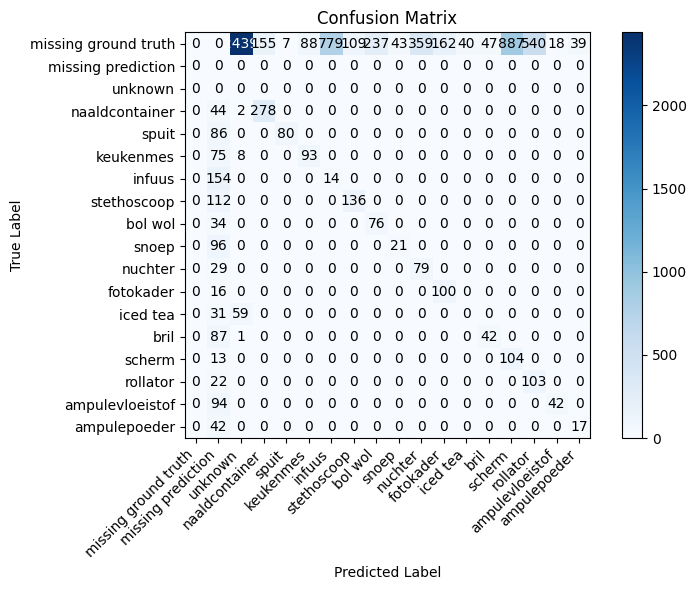

Best grid key: (0.6,)


In [32]:
# Select the grid key with the highest overall F1 score.
best_key = (0.6,)
best_metrics = grid_search_metrics[best_key]
best_confusion_matrix = grid_search_confusion_matrices[best_key]

render_confusion_matrix(best_confusion_matrix)

print(f"Best grid key: {best_key}")

In [13]:
import matplotlib.lines as mlines

# Definieer de grid parameters en de metrics die je wilt plotten.
grid_params = ["sample_count", "k", "confidence", "min_mask_area_size"]
metrics = ["precision", "recall", "f1", "unknown_rate"]

# Loop over elke class in de DataFrame.
for class_id in per_class_metrics_df["class_id"].unique():
    # Filter de DataFrame voor de huidige class.
    df_class = per_class_metrics_df[per_class_metrics_df["class_id"] == class_id]

    # Maak een figuur met horizontaal gestapelde subplots (één per grid parameter).
    fig, axes = plt.subplots(
        1, len(grid_params), figsize=(5 * len(grid_params), 4), sharey=True
    )

    # Zorg dat axes altijd een lijst is.
    if len(grid_params) == 1:
        axes = [axes]

    # Per subplot: groepeer op de huidige parameter en plot de lijnen voor elke metric.
    for ax, param in zip(axes, grid_params, strict=False):
        grouped = df_class.groupby(param)[metrics].mean().reset_index()

        for met in metrics:
            ax.plot(grouped[param], grouped[met], marker="o", color=color_mapping[met])

        ax.set_xlabel(param)
        ax.grid(True)
        ax.set_title(f"{CLASS_ID_TO_NAME.get(class_id, class_id)} - {param}")

    axes[0].set_ylabel("Metric waarde")

    # Maak één globale legende met vaste kleuren.
    legend_handles = []
    for met in metrics:
        line = mlines.Line2D(
            [], [], color=color_mapping[met], marker="o", markersize=4, label=met
        )
        legend_handles.append(line)

    fig.legend(
        handles=legend_handles,
        loc="upper center",
        ncol=len(metrics),
        bbox_to_anchor=(0.5, 1.05),
    )
    fig.suptitle(
        f"Metrics vs Parameters for {CLASS_ID_TO_NAME.get(class_id, class_id)}", y=1.12
    )
    plt.tight_layout()
    plt.show()

NameError: name 'per_class_metrics_df' is not defined

In [29]:
if FINAL_PREDICTIONS_PATH.exists():
    shutil.rmtree(FINAL_PREDICTIONS_PATH)
FINAL_PREDICTIONS_PATH.mkdir(parents=True, exist_ok=True)

for trial_recording_uuid in FULLY_LABELED_RECORDINGS:
    object_rois = object_rois_per_recording[trial_recording_uuid]
    object_df = object_df_per_recording[trial_recording_uuid]
    object_ids = object_df["object_id"].unique()

    predictions_df = object_df.copy()
    for object_id in object_ids:
        object_rows = object_df[object_df["object_id"] == object_id]
        rois = [
            object_rois[f"{object_id}_{int(row['frame_idx'])}"]
            for _, row in object_rows.iterrows()
        ]

        cls_id, cls_conf = fuse_track_by_majority_vote(
            object_rows, rois, model, conf_threshold=0.5
        )

        # add predicted_class_id and prediction_confidence to object_df based on object_id
        predictions_df.loc[object_df["object_id"] == object_id, "predicted_class_id"] = (
            cls_id
        )
        predictions_df.loc[
            object_df["object_id"] == object_id, "prediction_confidence"
        ] = cls_conf

    predictions_df.to_csv(
        FINAL_PREDICTIONS_PATH / f"{trial_recording_uuid}.csv", index=False
    )